# 10 Monkeys Classification



In [6]:
using Images, FileIO
using Augmentor
using Flux
using Flux: onehotbatch, onecold, logitcrossentropy, throttle
using Flux: @epochs
using Statistics

## Read images

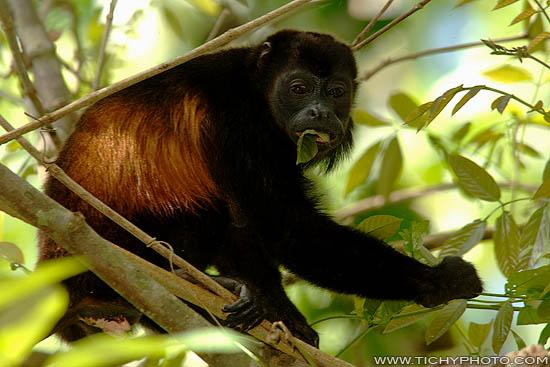

In [8]:
img = "training/training/n0/n0 (1).jpg"
load(img)

## Preprocessing

In [9]:
function toarray(img)
    img = Array{UInt8}(rawview(channelview(img)))
    Array{Float32,3}(cat(img[1,:,:], img[2,:,:], img[3,:,:]; dims=3) ./ 255)
end

toarray (generic function with 1 method)

In [10]:
pl = Resize(256, 256) |>
     Either(1=>FlipX(), 1=>NoOp()) |>
     Either(1=>Zoom(0.9:0.1:1.2), 1=>NoOp()) |>
     CropSize(256, 256)

4-step Augmentor.ImmutablePipeline:
 1.) Resize to 256×256
 2.) Either: (50%) Flip the X axis. (50%) No operation.
 3.) Either: (50%) Zoom by I ∈ {0.9×0.9, 1.0×1.0, 1.1×1.1, 1.2×1.2}. (50%) No operation.
 4.) Crop a 256×256 window around the center

In [11]:
function make_batch(X, y)
    newX = cat(X..., dims=4)
    newy = onehotbatch(y, 0:9)
    (newX, newy)
end

make_batch (generic function with 1 method)

In [12]:
function preprocess(root)
    Xs = Array{Float32,3}[]
    ys = Int[]
    for i = 0:9
        p = joinpath(root, "n$i")
        for img_path = readdir(p, join=true)
            img = load(img_path)
            img = augment(img, pl)
            X = toarray(img)
            push!(Xs, X)
            push!(ys, i)
        end
    end
    make_batch(Xs, ys)
end

preprocess (generic function with 1 method)

In [25]:
X_train, y_train = preprocess("training/training")
X_test, y_test = preprocess("validation/validation") ;

In [26]:
size(X_train)

(256, 256, 3, 1097)

## Data Loader

In [27]:
batchsize = 32
traindata = Flux.Data.DataLoader(X_train, y_train, batchsize=batchsize, shuffle=true);

## CNN Model

In [28]:
model = Chain(
    Conv((11, 11), 3=>96, stride=(4,4), relu),
    MaxPool((3,3), stride=(2,2)),
    Conv((5, 5), 96=>256, pad=(2,2), relu),
    MaxPool((3,3), stride=(2,2)),
    Conv((3, 3), 256=>384, pad=(1,1), relu),
    Conv((3, 3), 384=>384, pad=(1,1), relu),
    Conv((3, 3), 384=>256, pad=(1,1), relu),
    MaxPool((3,3), stride=(2,2)),
    flatten,
    Dense(9216, 4096),
    Dropout(0.5f0),
    Dense(4096, 10))

Chain(Conv((11, 11), 3=>96, relu), MaxPool((3, 3), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((5, 5), 96=>256, relu), MaxPool((3, 3), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 256=>384, relu), Conv((3, 3), 384=>384, relu), Conv((3, 3), 384=>256, relu), MaxPool((3, 3), pad = (0, 0, 0, 0), stride = (2, 2)), flatten, Dense(9216, 4096), Dropout(0.5), Dense(4096, 10))

In [29]:
model(X_train[:,:,:,1:3])

10×3 Array{Float32,2}:
  0.0234634    0.00979116  -0.0056468
 -0.0412694   -0.0241364   -0.029608
  0.00580308   0.0149237    0.0189507
  0.00978335  -0.0122028    0.00082083
 -0.0468927   -0.0843224   -0.032572
  0.0406688    0.0996081    0.0612065
  0.0200227   -0.00818136   0.00195378
  0.0733302    0.12162      0.0672721
 -0.0600144   -0.0216419   -0.0121953
  0.0829297    0.139577     0.0760152

## Loss

In [30]:
loss(x, y) = logitcrossentropy(model(x), y)

loss (generic function with 1 method)

In [31]:
accuracy(x, y, model) = mean(onecold(cpu(model(x))) .== onecold(cpu(y)))

accuracy (generic function with 1 method)

In [32]:
loss(X_train[:,:,:,1:3], y_train[:,1:3])

2.3110778f0

## Callback

In [33]:
function callback()
    print("Training ")
    @show loss(X_train, y_train)
    print("Testing ")
    @show loss(X_test, y_test)
    print("Testing ")
    @show accuracy(X_test, y_test, model)
    println()
end

callback (generic function with 1 method)

In [34]:
@epochs 20 Flux.train!(loss, params(model), traindata, ADAM(0.001), cb=throttle(callback, 10))

┌ Info: Epoch 1
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 79.029564f0
Testing loss(X_test, y_test) = 79.09879f0
Testing accuracy(X_test, y_test, model) = 0.09926470588235294

Training loss(X_train, y_train) = 2.3032994f0
Testing loss(X_test, y_test) = 2.3034344f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.34956f0
Testing loss(X_test, y_test) = 2.3504996f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.303884f0
Testing loss(X_test, y_test) = 2.3037791f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.305433f0
Testing loss(X_test, y_test) = 2.305333f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.308316f0
Testing loss(X_test, y_test) = 2.308337f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3059213f0
Testing loss(X_test, y_test) = 2.3058593f0
Testing

┌ Info: Epoch 2
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3029997f0
Testing loss(X_test, y_test) = 2.3028514f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3029168f0
Testing loss(X_test, y_test) = 2.3027627f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3033178f0
Testing loss(X_test, y_test) = 2.3033292f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3035002f0
Testing loss(X_test, y_test) = 2.30373f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.303812f0
Testing loss(X_test, y_test) = 2.3041935f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3034081f0
Testing loss(X_test, y_test) = 2.3038595f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3030105f0
Testing loss(X_test, y_test) = 2.3034592f0
Te

┌ Info: Epoch 3
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.302408f0
Testing loss(X_test, y_test) = 2.3023813f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3038976f0
Testing loss(X_test, y_test) = 2.3035865f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3054688f0
Testing loss(X_test, y_test) = 2.3049707f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.305704f0
Testing loss(X_test, y_test) = 2.3051586f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3057296f0
Testing loss(X_test, y_test) = 2.3051646f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3052647f0
Testing loss(X_test, y_test) = 2.304721f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3050022f0
Testing loss(X_test, y_test) = 2.30449f0
Test

┌ Info: Epoch 4
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3019412f0
Testing loss(X_test, y_test) = 2.3022497f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3027954f0
Testing loss(X_test, y_test) = 2.303228f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.3027277f0
Testing loss(X_test, y_test) = 2.303127f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3031533f0
Testing loss(X_test, y_test) = 2.3034654f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.303499f0
Testing loss(X_test, y_test) = 2.3036706f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.3033988f0
Testing loss(X_test, y_test) = 2.3035731f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.3033452f0
Testing loss(X_test, y_test) = 2.3035705f0
Te

┌ Info: Epoch 5
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3026686f0
Testing loss(X_test, y_test) = 2.302729f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3055387f0
Testing loss(X_test, y_test) = 2.305406f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.309209f0
Testing loss(X_test, y_test) = 2.3089783f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3103108f0
Testing loss(X_test, y_test) = 2.3099375f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.310476f0
Testing loss(X_test, y_test) = 2.3099728f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3075612f0
Testing loss(X_test, y_test) = 2.3071191f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3056493f0
Testing loss(X_test, y_test) = 2.3053591f0
Tes

┌ Info: Epoch 6
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3032138f0
Testing loss(X_test, y_test) = 2.3037186f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3057837f0
Testing loss(X_test, y_test) = 2.3065162f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.307396f0
Testing loss(X_test, y_test) = 2.3082488f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3086066f0
Testing loss(X_test, y_test) = 2.3093345f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3087175f0
Testing loss(X_test, y_test) = 2.3092277f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3074365f0
Testing loss(X_test, y_test) = 2.3077087f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3060884f0
Testing loss(X_test, y_test) = 2.306156f0
T

┌ Info: Epoch 7
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3029063f0
Testing loss(X_test, y_test) = 2.3028686f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3060892f0
Testing loss(X_test, y_test) = 2.306049f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.3068018f0
Testing loss(X_test, y_test) = 2.3069572f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.3053477f0
Testing loss(X_test, y_test) = 2.3056896f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.304037f0
Testing loss(X_test, y_test) = 2.304541f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3032565f0
Testing loss(X_test, y_test) = 2.3037293f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.30312f0
Testing loss(X_test, y_test) = 2.3035622f0
Test

┌ Info: Epoch 8
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3031518f0
Testing loss(X_test, y_test) = 2.303326f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3056433f0
Testing loss(X_test, y_test) = 2.3060584f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3055813f0
Testing loss(X_test, y_test) = 2.305956f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3047452f0
Testing loss(X_test, y_test) = 2.3051515f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.304529f0
Testing loss(X_test, y_test) = 2.3051608f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3051796f0
Testing loss(X_test, y_test) = 2.3059406f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3062227f0
Testing loss(X_test, y_test) = 2.307057f0
Tes

┌ Info: Epoch 9
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3031595f0
Testing loss(X_test, y_test) = 2.3031316f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3060436f0
Testing loss(X_test, y_test) = 2.3060856f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.304933f0
Testing loss(X_test, y_test) = 2.305012f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3041182f0
Testing loss(X_test, y_test) = 2.3043282f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3039763f0
Testing loss(X_test, y_test) = 2.3042474f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.303901f0
Testing loss(X_test, y_test) = 2.3043113f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3036773f0
Testing loss(X_test, y_test) = 2.3039985f0
Te

┌ Info: Epoch 10
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3026323f0
Testing loss(X_test, y_test) = 2.3024998f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3038516f0
Testing loss(X_test, y_test) = 2.3037152f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.3058293f0
Testing loss(X_test, y_test) = 2.3055892f0
Testing accuracy(X_test, y_test, model) = 0.09558823529411764

Training loss(X_train, y_train) = 2.305883f0
Testing loss(X_test, y_test) = 2.3058171f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.305203f0
Testing loss(X_test, y_test) = 2.3052404f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3053706f0
Testing loss(X_test, y_test) = 2.30548f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3052657f0
Testing loss(X_test, y_test) = 2.3054235f0
Tes

┌ Info: Epoch 11
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3038666f0
Testing loss(X_test, y_test) = 2.304217f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3065944f0
Testing loss(X_test, y_test) = 2.3070555f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.307822f0
Testing loss(X_test, y_test) = 2.3083396f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3083432f0
Testing loss(X_test, y_test) = 2.3089015f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.306593f0
Testing loss(X_test, y_test) = 2.3070261f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.304232f0
Testing loss(X_test, y_test) = 2.3044128f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3032515f0
Testing loss(X_test, y_test) = 2.3032904f0
Tes

┌ Info: Epoch 12
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3019412f0
Testing loss(X_test, y_test) = 2.3020258f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.303352f0
Testing loss(X_test, y_test) = 2.30328f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3058934f0
Testing loss(X_test, y_test) = 2.3058643f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3088412f0
Testing loss(X_test, y_test) = 2.3088117f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.308734f0
Testing loss(X_test, y_test) = 2.3086674f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3085706f0
Testing loss(X_test, y_test) = 2.3084543f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.308588f0
Testing loss(X_test, y_test) = 2.3085604f0
Test

┌ Info: Epoch 13
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3027847f0
Testing loss(X_test, y_test) = 2.3030667f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3035886f0
Testing loss(X_test, y_test) = 2.3040035f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3044348f0
Testing loss(X_test, y_test) = 2.3050752f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.304359f0
Testing loss(X_test, y_test) = 2.305011f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3041203f0
Testing loss(X_test, y_test) = 2.3048186f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3032212f0
Testing loss(X_test, y_test) = 2.3039117f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.302817f0
Testing loss(X_test, y_test) = 2.3035169f0
Te

┌ Info: Epoch 14
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3026955f0
Testing loss(X_test, y_test) = 2.3025796f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3054173f0
Testing loss(X_test, y_test) = 2.304915f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3075423f0
Testing loss(X_test, y_test) = 2.3068962f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.307967f0
Testing loss(X_test, y_test) = 2.3073308f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3078828f0
Testing loss(X_test, y_test) = 2.3071876f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.30821f0
Testing loss(X_test, y_test) = 2.3073933f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3081906f0
Testing loss(X_test, y_test) = 2.3073466f0
Tes

┌ Info: Epoch 15
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.304152f0
Testing loss(X_test, y_test) = 2.3049178f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3050263f0
Testing loss(X_test, y_test) = 2.305877f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.306438f0
Testing loss(X_test, y_test) = 2.3073843f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3055956f0
Testing loss(X_test, y_test) = 2.3063796f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.304432f0
Testing loss(X_test, y_test) = 2.3049963f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3041668f0
Testing loss(X_test, y_test) = 2.304482f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.303738f0
Testing loss(X_test, y_test) = 2.3037739f0
Testi

┌ Info: Epoch 16
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.302244f0
Testing loss(X_test, y_test) = 2.302182f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3034935f0
Testing loss(X_test, y_test) = 2.3035016f0
Testing accuracy(X_test, y_test, model) = 0.09926470588235294

Training loss(X_train, y_train) = 2.3035612f0
Testing loss(X_test, y_test) = 2.303778f0
Testing accuracy(X_test, y_test, model) = 0.09926470588235294

Training loss(X_train, y_train) = 2.3038533f0
Testing loss(X_test, y_test) = 2.304146f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.304963f0
Testing loss(X_test, y_test) = 2.3052065f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.306081f0
Testing loss(X_test, y_test) = 2.306387f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3063736f0
Testing loss(X_test, y_test) = 2.306707f0
Testing

┌ Info: Epoch 17
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3038294f0
Testing loss(X_test, y_test) = 2.304145f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3065102f0
Testing loss(X_test, y_test) = 2.3069158f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3078816f0
Testing loss(X_test, y_test) = 2.3082864f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3071818f0
Testing loss(X_test, y_test) = 2.3075237f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3056636f0
Testing loss(X_test, y_test) = 2.3059373f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3050098f0
Testing loss(X_test, y_test) = 2.3053362f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3044288f0
Testing loss(X_test, y_test) = 2.304873f0
T

┌ Info: Epoch 18
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3033977f0
Testing loss(X_test, y_test) = 2.3034565f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3073692f0
Testing loss(X_test, y_test) = 2.3071685f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3089168f0
Testing loss(X_test, y_test) = 2.308402f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3080382f0
Testing loss(X_test, y_test) = 2.307566f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3070395f0
Testing loss(X_test, y_test) = 2.306723f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3058524f0
Testing loss(X_test, y_test) = 2.3056464f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.304687f0
Testing loss(X_test, y_test) = 2.3045914f0
Tes

┌ Info: Epoch 19
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3026984f0
Testing loss(X_test, y_test) = 2.303164f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3031023f0
Testing loss(X_test, y_test) = 2.3033533f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3053324f0
Testing loss(X_test, y_test) = 2.305461f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.305685f0
Testing loss(X_test, y_test) = 2.305776f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3050027f0
Testing loss(X_test, y_test) = 2.3050547f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.304684f0
Testing loss(X_test, y_test) = 2.3045847f0
Testing accuracy(X_test, y_test, model) = 0.10294117647058823

Training loss(X_train, y_train) = 2.3041904f0
Testing loss(X_test, y_test) = 2.304136f0
Testi

┌ Info: Epoch 20
└ @ Main C:\Users\user\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


Training loss(X_train, y_train) = 2.3039935f0
Testing loss(X_test, y_test) = 2.30427f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.308642f0
Testing loss(X_test, y_test) = 2.3084085f0
Testing accuracy(X_test, y_test, model) = 0.09926470588235294

Training loss(X_train, y_train) = 2.3105464f0
Testing loss(X_test, y_test) = 2.310445f0
Testing accuracy(X_test, y_test, model) = 0.09926470588235294

Training loss(X_train, y_train) = 2.312462f0
Testing loss(X_test, y_test) = 2.3124716f0
Testing accuracy(X_test, y_test, model) = 0.09926470588235294

Training loss(X_train, y_train) = 2.3116548f0
Testing loss(X_test, y_test) = 2.3118353f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.30995f0
Testing loss(X_test, y_test) = 2.3103375f0
Testing accuracy(X_test, y_test, model) = 0.11029411764705882

Training loss(X_train, y_train) = 2.3078651f0
Testing loss(X_test, y_test) = 2.308298f0
Testing